In [5]:
from matplotlib import pyplot as plt
import pandas as pd
import json
import os

def prepare_data(pth_json, pth_models, pth_offers):
    def is_top_5(category_rankings):
        for i in category_rankings:
            for k in range(5 - len(category_rankings[i])): # все предикты top-k делаем длиной 5
                category_rankings[i].append((0, 0, 0))#((index_of_first, 0, 0))#(category_rankings[i][- 1])
            assert len(category_rankings[i]) == 5
        return category_rankings
    
    with open(pth_json, 'r') as fp:
        data = json.load(fp)

    data = {int(k):v for k,v in data.items()} #  a list of (passage_id, rank, score) for the top-k passages
    data = is_top_5(data)

    df_models = pd.read_csv(pth_models, sep=";")
    df_models = df_models.drop(columns=['average_price', 'comment'])
    df_offers = pd.read_csv(pth_offers, sep=";")
    df_offers = df_offers.drop(columns=['true_match', 'false_match'])

    for i in data: # data[i] is a list of (passage_id, rank, score) for the top-k passages
        model_ids = [df_models.iloc[x[0]].model_id for x in data[i]]
        confidences = [x[2] for x in data[i]]

        df_offers.at[i, 'model_id_pred'] = f"{model_ids[0]},{model_ids[1]},{model_ids[2]},{model_ids[3]},{model_ids[4]}"
        df_offers.at[i,'confidence'] = f"{confidences[0]},{confidences[1]},{confidences[2]},{confidences[3]},{confidences[4]}"

    df_offers = df_offers.iloc[list(data.keys())].reset_index(drop=True)

    def split(x):
        return [int(i) for i in x.split(",")]
    def split2(x):
        return [float(i) for i in x.split(",")]

    df_offers['model_id_pred'] = df_offers['model_id_pred'].apply(split)
    df_offers['confidence'] = df_offers['confidence'].apply(split2)

    return data, df_models, df_offers

def accuracy_top_n(offer_model_id, offer_model_id_pred, top_k):
    correct_predictions = 0

    for true_id, predicted_ids in zip(offer_model_id, offer_model_id_pred):
        top_k_predictions = predicted_ids[:top_k]
        if true_id in top_k_predictions:
            correct_predictions += 1

    accuracy = correct_predictions / len(offer_model_id)
    return accuracy

def calculate_precision_recall(offer_model_id, offer_model_id_pred, top_k): # проверить функцию
    true_positives = 0
    false_positives = 0
    false_negatives = 0

    for true_id, predicted_ids in zip(offer_model_id, offer_model_id_pred):
        top_k_predictions = predicted_ids[:top_k]
        
        if true_id in top_k_predictions:
            true_positives += 1
        else:
            false_negatives += 1
            false_positives += (true_id in predicted_ids)

    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0

    return precision, recall

def calc_acc_for_category(df_offers, df_models, imya_kategorii):
    print(f"{imya_kategorii}")
    df_offers = df_offers[df_offers.category_name == imya_kategorii]
    df_models = df_models[df_models.category_name == imya_kategorii]

    offer_names = list(df_offers['name'])
    offer_model_id = list(df_offers['model_id'])
    offer_model_id_pred = list(df_offers['model_id_pred'])

    model_full_names = list(df_models['full_name'])

    print(f"\tофферов {len(offer_model_id)} шт поиск матча для каждого среди {len(model_full_names)} шт моделей:\n")

    top1_accuracy = accuracy_top_n(offer_model_id, offer_model_id_pred, 1)
    top3_accuracy = accuracy_top_n(offer_model_id, offer_model_id_pred, 3)
    top5_accuracy = accuracy_top_n(offer_model_id, offer_model_id_pred, 5)

    top1_precision, top1_recall = calculate_precision_recall(offer_model_id, offer_model_id_pred, top_k=1)
    top3_precision, top3_recall = calculate_precision_recall(offer_model_id, offer_model_id_pred, top_k=3)
    top5_precision, top5_recall = calculate_precision_recall(offer_model_id, offer_model_id_pred, top_k=5)

    print(f'\tTop-1: Accuracy = {top1_accuracy:.2%}')
    print(f'\tTop-3: Accuracy = {top3_accuracy:.2%}')
    print(f'\tTop-5: Accuracy = {top5_accuracy:.2%}\n')

    # print(f'\tTop-1: Accuracy = {top1_accuracy:.2%}, Precision = {top1_precision:.2%}, Recall = {top1_recall:.2%}')
    # print(f'\tTop-3: Accuracy = {top3_accuracy:.2%}, Precision = {top3_precision:.2%}, Recall = {top3_recall:.2%}')
    # print(f'\tTop-5: Accuracy = {top5_accuracy:.2%}, Precision = {top5_precision:.2%}, Recall = {top5_recall:.2%}\n')
    return top1_accuracy, top3_accuracy, top5_accuracy

In [6]:
pth_models = "/home/sondors/Documents/price/ColBERT_data/18_categories/test/models_18_categories.csv"
pth_offers = "/home/sondors/Documents/price/ColBERT_data/18_categories/test/triplets_test_18_categories.csv"
pth_fld_json = "/home/sondors/Documents/price/ColBERT_data/18_categories/metrics_data/EVAL/triplets_shuffle"

categories = [
    "диктофоны, портативные рекордеры",
    "электронные книги",
    "автомобильные телевизоры, мониторы",
    "смарт-часы и браслеты",
    "портативные медиаплееры",
    "чехлы, обложки для гаджетов (телефонов, планшетов etc)",
    "портативная акустика",
    "мобильные телефоны",
    "VR-гарнитуры (VR-очки, шлемы, очки виртуальной реальности, FPV очки для квадрокоптеров)",
    "планшетные компьютеры и мини-планшеты",
    "наушники, гарнитуры, наушники c микрофоном",
    "радиоприемники, радиобудильники, радиочасы",
    "магнитолы",
    "GPS-навигаторы"
    ]

filenames_int = []
accuracy_all_models = []
for pth in os.listdir(pth_fld_json):
    pth_json = os.path.join(pth_fld_json, pth)
    filenames_int.append(int(pth[len("triples_shuffle_colbert-"):len("triples_shuffle_colbert-")+4]))
    
    data, df_models, df_offers = prepare_data(pth_json, pth_models, pth_offers)

    accuracy_one_model = []
    for category in categories:
        top1_accuracy, top3_accuracy, top5_accuracy = calc_acc_for_category(df_offers, df_models, category)
        accuracy_one_model.append(top1_accuracy)
    accuracy_all_models.append(accuracy_one_model)
accuracy_all_categories = list(map(list, zip(*accuracy_all_models)))

/tmp/ipykernel_518869/2173797751.py:20: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df_models = pd.read_csv(pth_models, sep=";")


диктофоны, портативные рекордеры
	офферов 251 шт поиск матча для каждого среди 488 шт моделей:

	Top-1: Accuracy = 90.44%
	Top-3: Accuracy = 94.02%
	Top-5: Accuracy = 95.22%

электронные книги
	офферов 367 шт поиск матча для каждого среди 680 шт моделей:

	Top-1: Accuracy = 90.46%
	Top-3: Accuracy = 94.55%
	Top-5: Accuracy = 94.82%

автомобильные телевизоры, мониторы
	офферов 100 шт поиск матча для каждого среди 790 шт моделей:

	Top-1: Accuracy = 69.00%
	Top-3: Accuracy = 74.00%
	Top-5: Accuracy = 77.00%

смарт-часы и браслеты
	офферов 6083 шт поиск матча для каждого среди 2577 шт моделей:

	Top-1: Accuracy = 86.09%
	Top-3: Accuracy = 92.42%
	Top-5: Accuracy = 94.33%

портативные медиаплееры
	офферов 589 шт поиск матча для каждого среди 847 шт моделей:

	Top-1: Accuracy = 89.64%
	Top-3: Accuracy = 94.06%
	Top-5: Accuracy = 95.42%

чехлы, обложки для гаджетов (телефонов, планшетов etc)
	офферов 7978 шт поиск матча для каждого среди 37045 шт моделей:

	Top-1: Accuracy = 49.55%
	Top-3: A

/tmp/ipykernel_518869/2173797751.py:20: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df_models = pd.read_csv(pth_models, sep=";")


диктофоны, портативные рекордеры
	офферов 251 шт поиск матча для каждого среди 488 шт моделей:

	Top-1: Accuracy = 90.04%
	Top-3: Accuracy = 93.63%
	Top-5: Accuracy = 95.62%

электронные книги
	офферов 367 шт поиск матча для каждого среди 680 шт моделей:

	Top-1: Accuracy = 89.65%
	Top-3: Accuracy = 94.55%
	Top-5: Accuracy = 95.37%

автомобильные телевизоры, мониторы
	офферов 100 шт поиск матча для каждого среди 790 шт моделей:

	Top-1: Accuracy = 69.00%
	Top-3: Accuracy = 74.00%
	Top-5: Accuracy = 76.00%

смарт-часы и браслеты
	офферов 6083 шт поиск матча для каждого среди 2577 шт моделей:

	Top-1: Accuracy = 85.81%
	Top-3: Accuracy = 92.27%
	Top-5: Accuracy = 94.26%

портативные медиаплееры
	офферов 589 шт поиск матча для каждого среди 847 шт моделей:

	Top-1: Accuracy = 89.81%
	Top-3: Accuracy = 94.06%
	Top-5: Accuracy = 94.91%

чехлы, обложки для гаджетов (телефонов, планшетов etc)
	офферов 7978 шт поиск матча для каждого среди 37045 шт моделей:

	Top-1: Accuracy = 49.34%
	Top-3: A

/tmp/ipykernel_518869/2173797751.py:20: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df_models = pd.read_csv(pth_models, sep=";")


диктофоны, портативные рекордеры
	офферов 251 шт поиск матча для каждого среди 488 шт моделей:

	Top-1: Accuracy = 89.64%
	Top-3: Accuracy = 92.03%
	Top-5: Accuracy = 93.63%

электронные книги
	офферов 367 шт поиск матча для каждого среди 680 шт моделей:

	Top-1: Accuracy = 88.83%
	Top-3: Accuracy = 94.28%
	Top-5: Accuracy = 95.37%

автомобильные телевизоры, мониторы
	офферов 100 шт поиск матча для каждого среди 790 шт моделей:

	Top-1: Accuracy = 68.00%
	Top-3: Accuracy = 73.00%
	Top-5: Accuracy = 77.00%

смарт-часы и браслеты
	офферов 6083 шт поиск матча для каждого среди 2577 шт моделей:

	Top-1: Accuracy = 85.52%
	Top-3: Accuracy = 92.26%
	Top-5: Accuracy = 94.20%

портативные медиаплееры
	офферов 589 шт поиск матча для каждого среди 847 шт моделей:

	Top-1: Accuracy = 90.32%
	Top-3: Accuracy = 94.06%
	Top-5: Accuracy = 95.42%

чехлы, обложки для гаджетов (телефонов, планшетов etc)
	офферов 7978 шт поиск матча для каждого среди 37045 шт моделей:

	Top-1: Accuracy = 48.73%
	Top-3: A

/tmp/ipykernel_518869/2173797751.py:20: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df_models = pd.read_csv(pth_models, sep=";")


диктофоны, портативные рекордеры
	офферов 251 шт поиск матча для каждого среди 488 шт моделей:

	Top-1: Accuracy = 89.24%
	Top-3: Accuracy = 93.23%
	Top-5: Accuracy = 97.21%

электронные книги
	офферов 367 шт поиск матча для каждого среди 680 шт моделей:

	Top-1: Accuracy = 84.20%
	Top-3: Accuracy = 93.73%
	Top-5: Accuracy = 94.82%

автомобильные телевизоры, мониторы
	офферов 100 шт поиск матча для каждого среди 790 шт моделей:

	Top-1: Accuracy = 69.00%
	Top-3: Accuracy = 75.00%
	Top-5: Accuracy = 78.00%

смарт-часы и браслеты
	офферов 6083 шт поиск матча для каждого среди 2577 шт моделей:

	Top-1: Accuracy = 85.30%
	Top-3: Accuracy = 92.19%
	Top-5: Accuracy = 94.05%

портативные медиаплееры
	офферов 589 шт поиск матча для каждого среди 847 шт моделей:

	Top-1: Accuracy = 88.79%
	Top-3: Accuracy = 94.06%
	Top-5: Accuracy = 95.08%

чехлы, обложки для гаджетов (телефонов, планшетов etc)
	офферов 7978 шт поиск матча для каждого среди 37045 шт моделей:

	Top-1: Accuracy = 47.76%
	Top-3: A

/tmp/ipykernel_518869/2173797751.py:20: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df_models = pd.read_csv(pth_models, sep=";")


диктофоны, портативные рекордеры
	офферов 251 шт поиск матча для каждого среди 488 шт моделей:

	Top-1: Accuracy = 89.64%
	Top-3: Accuracy = 94.02%
	Top-5: Accuracy = 96.41%

электронные книги
	офферов 367 шт поиск матча для каждого среди 680 шт моделей:

	Top-1: Accuracy = 85.01%
	Top-3: Accuracy = 94.28%
	Top-5: Accuracy = 94.82%

автомобильные телевизоры, мониторы
	офферов 100 шт поиск матча для каждого среди 790 шт моделей:

	Top-1: Accuracy = 69.00%
	Top-3: Accuracy = 77.00%
	Top-5: Accuracy = 77.00%

смарт-часы и браслеты
	офферов 6083 шт поиск матча для каждого среди 2577 шт моделей:

	Top-1: Accuracy = 83.82%
	Top-3: Accuracy = 90.88%
	Top-5: Accuracy = 93.31%

портативные медиаплееры
	офферов 589 шт поиск матча для каждого среди 847 шт моделей:

	Top-1: Accuracy = 89.64%
	Top-3: Accuracy = 93.38%
	Top-5: Accuracy = 95.42%

чехлы, обложки для гаджетов (телефонов, планшетов etc)
	офферов 7978 шт поиск матча для каждого среди 37045 шт моделей:

	Top-1: Accuracy = 48.36%
	Top-3: A

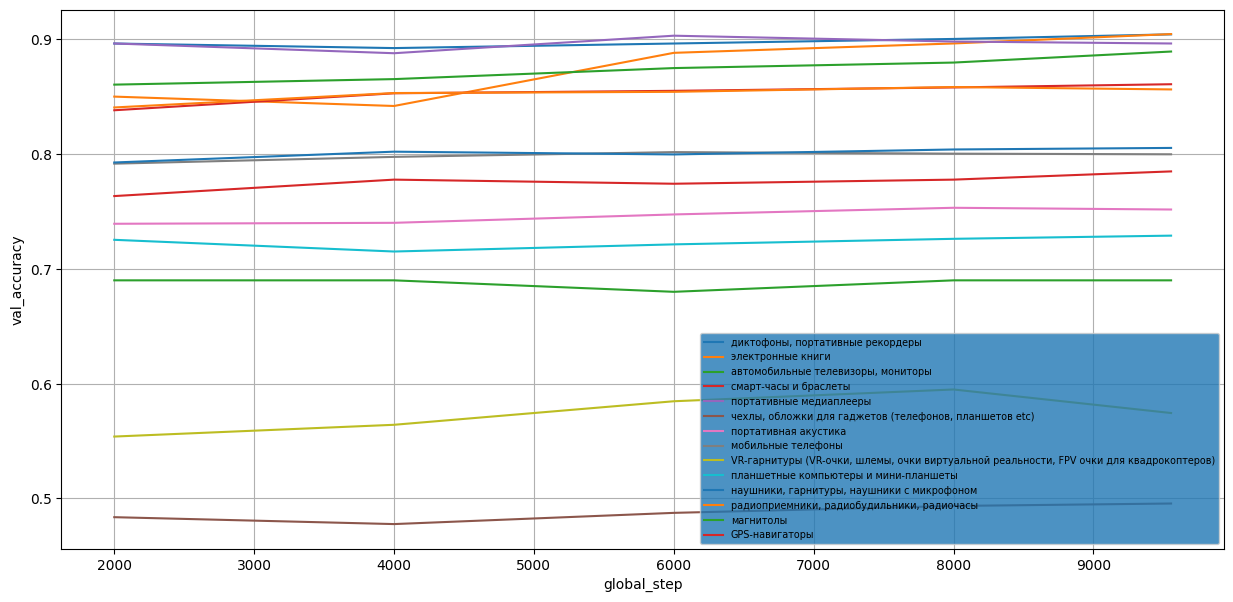

In [7]:
def plot_epochs_accuracy(filenames_int, accuracy_all, categories, y_axe='val_accuracy', x_axe='epoch'):
    plt.rcParams['figure.figsize'] = [15, 7]
    fig, ax = plt.subplots()

    for i in range(len(categories)):
        ax.plot(filenames_int, accuracy_all[i], label=categories[i])
    plt.xlabel(x_axe)
    plt.ylabel(y_axe)


    legend = ax.legend(loc='lower right', shadow=False, fontsize='x-small')

    # Put a nicer background color on the legend.
    legend.get_frame().set_facecolor('C0')
    plt.grid()
    plt.show()

plot_epochs_accuracy(filenames_int, accuracy_all_categories, categories, y_axe='val_accuracy', x_axe='global_step')